In [1]:
import pandas as pd
import numpy as np
import config
from fredapi import Fred

# User will need a FRED API key, can sign up for one here https://fred.stlouisfed.org/docs/api/api_key.html
# replace with your own API key: fred = Fred(api_key='YOUR KEY HERE')
fred = Fred(api_key=config.api_key)

"""
DEFINE: fredget() => a function to retrieve series, store info, and plot data 
-----------------------INPUTS -------------------------------
varlist: a list of FRED codes ex. FRED_list = ['GDP','SP500']
start_date & end_date: set the chosen sample ex. start_d ='1990-01-01'
plots (Optional): True/False => set whether to show a preview of the data during collection
freq (Optional): default is not to synchronize frequencies: choose 'm','q','a' if aggregating
name_map (Optional):dict containing remapped variable names for plot default titles
------------------------OUTPUTS -----------------------------
df_collect: the compiled data df with date set as index
info_store: DF containing series info (units, titles, notes, etc.)
"""

def fredget(varlist, start_date, end_date, plots=True,freq="",name_map = dict()):
    df_collect = pd.DataFrame()

    for var in varlist:
        df_add = fred.get_series(var, observation_start = start_date, observation_end=end_date, frequency =freq).to_frame(name = var)
        info_add = fred.get_series_info(var).to_frame(name = var)
        print(var)
        #If user changes the 
        if freq != "":
            info_add.loc['cur_freq', var] = freq
            
        if var in name_map:
            info_add.loc['user_title', var] = name_map[var]
        else:
            info_add.loc['user_title', var] = info_add.loc['title', var]
                    
        if plots == True:
            df_add.plot(y=var, use_index=True, kind='line', title = info_add.loc['user_title', var], ylabel = info_add.loc['units', var] )
            
        if df_collect.empty == True:
            df_collect = df_add
            info_store = info_add
        else:
            df_collect = pd.merge(df_collect, df_add, left_index=True, right_index=True, how='outer')
            info_store = pd.merge(info_store, info_add, left_index=True, right_index=True, how='left')
            
    df_collect.sort_index()
    return df_collect, info_store



DCOILWTICO
DEXCAUS


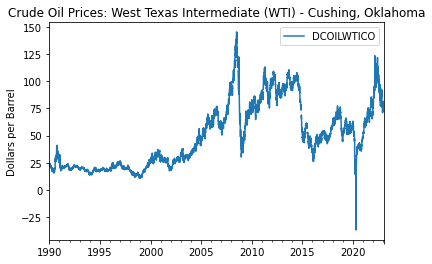

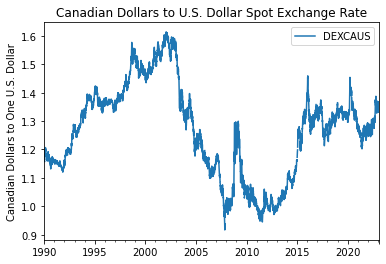

In [2]:
#Example of a function call
start_d ='1990-01-01'
end_d= '2023-02-03'
fq = "d" 
FRED_list = ['DCOILWTICO','DEXCAUS']
Name_remap = {}

df,dfinfo = fredget(FRED_list, start_d, end_d, freq = fq, plots=True, name_map = Name_remap)

The shape of the df before dropping nans (8635, 2)
The shape of the df AFTER dropping nans (8239, 2)


/Users/wcrossb/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/wcrossb/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Text(0.5, 1.0, 'Local projection Response')

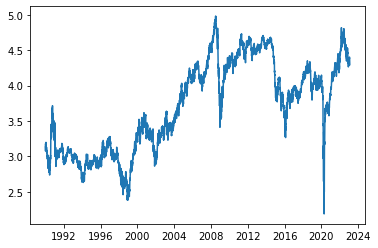

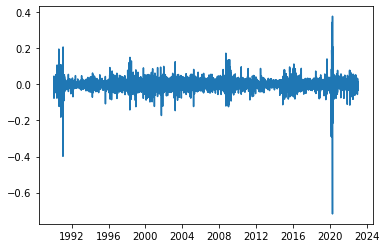

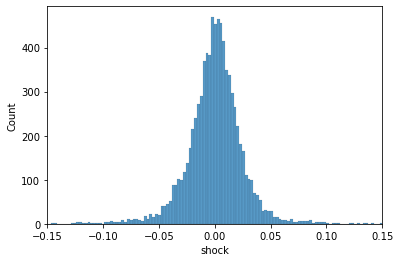

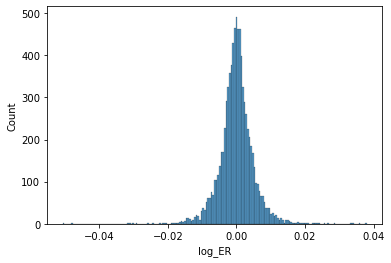

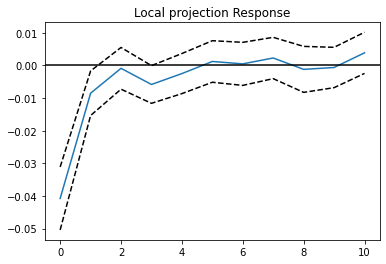

In [3]:
from statsmodels.tsa.ar_model import AutoReg
from lppy import locproj
from matplotlib import pyplot as plt 
import seaborn as sns 

print(f"The shape of the df before dropping nans {df.shape}")
df.dropna(inplace=True)
print(f"The shape of the df AFTER dropping nans {df.shape}")

lag_l =10
df['log_oilprice'] = np.log(df.DCOILWTICO)
df['log_ER'] = np.log(df.DEXCAUS)
df['log_ER'] = df['log_ER'] - df['log_ER'].shift(1)
df.dropna(inplace=True)
armodel = AutoReg(df.log_oilprice,lags=lag_l).fit()
df['shock'] = df.log_oilprice - armodel.fittedvalues

plt.plot(df['log_oilprice'])
plt.figure()

plt.plot(df['shock'])
plt.figure()
sns.histplot(df['shock'])
plt.xlim((-.15, .15))
plt.figure()
sns.histplot(df['log_ER'])

control_names = []
for i in range(1,13):
    df[f'ER_lag{i}'] = df.log_ER.shift(i)
    control_names.append(f'ER_lag{i}')

control_names.append('shock')

df = df.tail(-20)
exog = df[control_names]
Y = df['log_ER'].to_numpy()

irf = locproj(exog.to_numpy(),Y,12,10,99)
plt.figure()
plt.plot(irf.resp)
plt.plot(irf.se_low,'k--')
plt.plot(irf.se_high,'k--')
plt.axhline(y = 0, color = 'black', linestyle = '-')


plt.title("Local projection Response")  
